In [1]:
import numpy as np
import matplotlib.pyplot as plt
from subprocess import Popen, PIPE

hbar = 0.658
from numpy import genfromtxt
plt.rc('text', usetex=True)

import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

#add directory to path
import sys
sys.path.append('../source')

from qutip_master_eq import *


ModuleNotFoundError: No module named 'seaborn'

In [4]:
# Parameters for simulations
devices = [[SiGe,Struck],[GaAsN,Malinowski]] #devices -> defined in the functions_utils.py
tuns = [40]  #tunnel coupling
dzs = [1e-3] #difference in spin splitting
Ezs = [30]   #average spin splitting
eps0 = 250   #sweep range -eps0 to eps0
trials = 5  #number of trials (for averaging, suggested >10)
siges = [5]  #amplitude of detuning low-frequency noise
sigts = [0]  #amplitude of tunnel-coupling low-frequency noise
T = [100]    #temperature
#spin-orbit coupling (SOC)
bxs = [0] #gradient-based (synthetic)
ars = [0] #real part of intrinsic SOC
aims = [0.1] #imaginary part of intrinsic SOC


Ngrid = 200  #number of grid points for inetrpolating spectral denisty
emin = 2     #minimal energy for interpolation

vs = np.logspace(0,3,11) #sweep rates range

#take combinations of parameters
datas = cart_dict(cartesian([tuns,dzs,Ezs,siges,sigts,vs,T,bxs,aims,ars,eps0]),
                  ["tun","dz","Ez","sige","sigt","v","T","bx","aim","ar","eps0"])


In [5]:
# run simulations

res_master = np.zeros((2,6,len(datas)),dtype=complex)
for mn,mat in enumerate(devices):
    for r,data in enumerate(datas):
        res_master[mn,:,r] = run_master_qutip(mat,mn, data, trials, psi0 = (1,1),phase_correct = False)
  

/Users/krzywdaja/Decoherence-in-shuttling-code/code/source/functions_utils.py:102: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  I = integrate.quad(lambda th: sin(th) *D(mat)[pol](th)**2 *


0 1.0
0 1.9952623149688795
0 3.9810717055349722
0 7.943282347242813
0 15.848931924611133
0 31.622776601683793
0 63.0957344480193
0 125.89254117941675
0 251.18864315095797
0 501.18723362727195
0 1000.0
1 1.0
1 1.9952623149688795
1 3.9810717055349722
1 7.943282347242813
1 15.848931924611133
1 31.622776601683793
1 63.0957344480193
1 125.89254117941675
1 251.18864315095797
1 501.18723362727195
1 1000.0


In [4]:
def load_data(datas, x_axis = "v"):
    '''
    Load data from the simulation results and parameters

    Parameters
    ----------
    datas : list of dict
        List of dictionaries containing the parameters of the simulations
    x_axis : str
        The parameter to be used as the x-axis
    
    Returns
    -------
    ymat : np.array
        The data to be plotted dims = (device,parameter_set,xvalues,outcome)
        where outcome:
            [0] Coherence in the ground state
            [1] Coherence in the excited state
            [2] Population in the excited dn state
            [3] Population in the excited up state
            [4] Population in the ground dn state
            [5] Population in the ground up state
    parameters : list of dict
        The parameters of the simulations (second axis of ymat)


    '''
    data_filter = [{k: dat[k] for k in set(list(dat.keys())) - set([x_axis])} for dat in datas]
    parameters = list(map(dict, set(tuple(sorted(d.items())) for d in data_filter)))
    ymat = []
    for mn,mat in enumerate(devices):
        ys_m = []
        for param in parameters:
            you = []
            ym = []
            for dn,data in enumerate(datas):
                #use third axis as a plotting axis
                if ({k: data[k] for k in set(list(data.keys())) - set([x_axis])}==param):  #change v
                    #you.append(res_ou[:,dn])
                    ym.append(res_master[mn,:,dn])
            ys_m.append(np.array(ym))
        ymat.append(ys_m)
        
        
    ymat = np.array(ymat)
    return ymat, parameters

results, parameters = load_data(datas, x_axis = "v")
results.shape

(1, 1, 5, 6)

0.001 0.0 0.1
0.11905010471907188


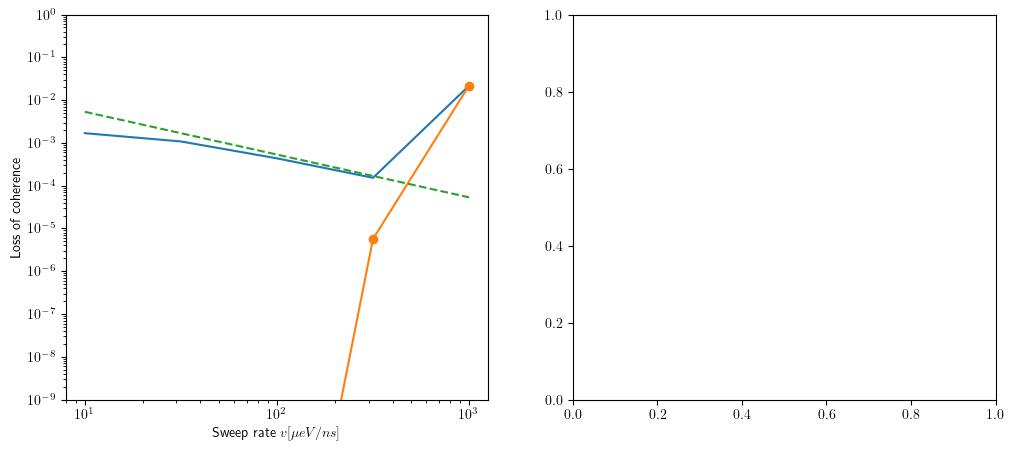

In [5]:
fig, ax = plt.subplots(1,2,figsize=(12,5))

for ind_dev,data in enumerate(results): #first index is the device
    for ind_param,data2 in enumerate(data):   #second index is the parameter set
        params = parameters[ind_param] 
        print(params["dz"],params["bx"],params["aim"])
        dWg = 1-2*np.abs(data2[:,0])  #loss of coherence
        
        
        ax[ind_dev].plot(vs,dWg) 
        ax[ind_dev].plot(vs, LZ(vs, params["tun"]), '-o')


        gamma_m = S_z(params["tun"], devices[ind_dev],params["T"])/4/hbar**2
        print(gamma_m)
        ax[ind_dev].plot(vs, SEAL(vs, gamma_m, params["tun"],params["T"]), "--")

    ax[ind_dev].set_xscale("log")
    ax[ind_dev].set_yscale("log")
    ax[ind_dev].set_xlabel("Sweep rate $v [\mu eV/ns]$")
    ax[ind_dev].set_ylabel("Loss of coherence")
    ax[ind_dev].set_ylim(bottom=1e-9, top = 1e0)

               